# Monte Carlo Ranom Forest + Linear Regression

In [3]:
import pandas as pd
import geopandas as gpd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
from time import time
import json
import sys

from thorr.utils import read_config

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import root_mean_squared_error, mean_squared_error, r2_score

from sklearn.model_selection import KFold, ShuffleSplit, RepeatedKFold, train_test_split, ParameterGrid
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.linear_model import ElasticNetCV, ElasticNet, LinearRegression
from sklearn.inspection import permutation_importance

from joblib import dump, load

from permetrics.regression import RegressionMetric
from quantile_forest import RandomForestQuantileRegressor

import glob

In [5]:
config_path = Path('/Users/gdarkwah/Library/CloudStorage/OneDrive-UW/01-Research/03-HAB/.env/hab_config.ini')
config_dict = read_config(config_path)
project_dir = Path(config_dict["project"]["project_dir"])

In [6]:
results_dir = Path('/Volumes/STLP-0800/monte_carlo_rfr_base_1_std/')
dev_results_dir = results_dir / 'dev_results'
dev_results_dir.mkdir(parents=True, exist_ok=True)
dev_models_dir = results_dir / 'dev_models'
dev_models_dir.mkdir(parents=True, exist_ok=True)
test_results_dir = results_dir / 'test_results'
test_results_dir.mkdir(parents=True, exist_ok=True)
final_models_dir = results_dir / 'final_models'
final_models_dir.mkdir(parents=True, exist_ok=True)

## Analysis

In [7]:
train_results_df = pd.concat([pd.read_csv(f) for f in glob.glob(str(dev_results_dir) + '/*train*.csv')], ignore_index=True)
val_results_df = pd.concat([pd.read_csv(f) for f in glob.glob(str(dev_results_dir) + '/*val*.csv')], ignore_index=True)
test_results_df = pd.read_csv(test_results_dir / 'monte_carlo_test_results.csv', parse_dates=['Date'])
test_results_df['pred_chl_a'] = 10**test_results_df['pred_log_chl_a']


In [8]:
train_stats_group = train_results_df.groupby(['Date', 'ReachID', ])
train_stats = []
for (Date, ReachID), group in train_stats_group:
    
    perc_5_log_chl_a = group["pred_log_chl_a"].quantile(0.05)
    perc_25_log_chl_a = group["pred_log_chl_a"].quantile(0.25)
    perc_50_log_chl_a = group["pred_log_chl_a"].quantile(0.50)
    perc_75_log_chl_a = group["pred_log_chl_a"].quantile(0.75)
    perc_95_log_chl_a = group["pred_log_chl_a"].quantile(0.95)
    mean_log_chl_a = group["pred_log_chl_a"].mean()
    true_log_chl_a = group["log_chl_a"].iloc[0]
    
    perc_5_chl_a = 10**perc_5_log_chl_a
    perc_25_chl_a = 10**perc_25_log_chl_a
    perc_50_chl_a = 10**perc_50_log_chl_a
    perc_75_chl_a = 10**perc_75_log_chl_a
    perc_95_chl_a = 10**perc_95_log_chl_a
    mean_chl_a = 10**mean_log_chl_a
    true_chl_a = 10**true_log_chl_a

    predicted_chl_a = perc_50_chl_a # using median, but may use the mean instead.

    lower_error = predicted_chl_a - perc_25_chl_a
    upper_error = perc_75_chl_a - predicted_chl_a

    train_stats.append(pd.DataFrame({
        'Date': Date,
        'ReachID': ReachID,
        'true_log_chl_a': true_log_chl_a,
        'perc_5_log_chl_a': perc_5_log_chl_a,
        'perc_25_log_chl_a': perc_25_log_chl_a,
        'perc_50_log_chl_a': perc_50_log_chl_a,
        'perc_75_log_chl_a': perc_75_log_chl_a,
        'perc_95_log_chl_a': perc_95_log_chl_a,
        'mean_log_chl_a': mean_log_chl_a,
        'true_chl_a': true_chl_a,
        'perc_5_chl_a': perc_5_chl_a,
        'perc_25_chl_a': perc_25_chl_a,
        'perc_50_chl_a': perc_50_chl_a,
        'perc_75_chl_a': perc_75_chl_a,
        'perc_95_chl_a': perc_95_chl_a,
        'mean_chl_a': mean_chl_a,
        'lower_error': lower_error,
        'upper_error': upper_error,
    }, index=[0]))

train_stats_df = pd.concat(train_stats, ignore_index=True)

train_stats_df['residuals'] = train_stats_df['true_log_chl_a'] - train_stats_df['perc_50_log_chl_a']
train_residual_mean = train_stats_df['residuals'].mean()
train_residual_std = train_stats_df['residuals'].std()

del train_results_df

In [9]:
val_stats_group = val_results_df.groupby(['Date', 'ReachID', ])
val_stats = []
for (Date, ReachID), group in val_stats_group:
    
    perc_5_log_chl_a = group["pred_log_chl_a"].quantile(0.05)
    perc_25_log_chl_a = group["pred_log_chl_a"].quantile(0.25)
    perc_50_log_chl_a = group["pred_log_chl_a"].quantile(0.50)
    perc_75_log_chl_a = group["pred_log_chl_a"].quantile(0.75)
    perc_95_log_chl_a = group["pred_log_chl_a"].quantile(0.95)
    mean_log_chl_a = group["pred_log_chl_a"].mean()
    true_log_chl_a = group["log_chl_a"].iloc[0]
    
    perc_5_chl_a = 10**perc_5_log_chl_a
    perc_25_chl_a = 10**perc_25_log_chl_a
    perc_50_chl_a = 10**perc_50_log_chl_a
    perc_75_chl_a = 10**perc_75_log_chl_a
    perc_95_chl_a = 10**perc_95_log_chl_a
    mean_chl_a = 10**mean_log_chl_a
    true_chl_a = 10**true_log_chl_a

    predicted_chl_a = perc_50_chl_a # using median, but may use the mean instead.

    lower_error = predicted_chl_a - perc_25_chl_a
    upper_error = perc_75_chl_a - predicted_chl_a

    val_stats.append(pd.DataFrame({
        'Date': Date,
        'ReachID': ReachID,
        'true_log_chl_a': true_log_chl_a,
        'perc_5_log_chl_a': perc_5_log_chl_a,
        'perc_25_log_chl_a': perc_25_log_chl_a,
        'perc_50_log_chl_a': perc_50_log_chl_a,
        'perc_75_log_chl_a': perc_75_log_chl_a,
        'perc_95_log_chl_a': perc_95_log_chl_a,
        'mean_log_chl_a': mean_log_chl_a,
        'true_chl_a': true_chl_a,
        'perc_5_chl_a': perc_5_chl_a,
        'perc_25_chl_a': perc_25_chl_a,
        'perc_50_chl_a': perc_50_chl_a,
        'perc_75_chl_a': perc_75_chl_a,
        'perc_95_chl_a': perc_95_chl_a,
        'mean_chl_a': mean_chl_a,
        'lower_error': lower_error,
        'upper_error': upper_error,
    }, index=[0]))

val_stats_df = pd.concat(val_stats, ignore_index=True)

val_stats_df['residuals'] = val_stats_df['true_log_chl_a'] - val_stats_df['perc_50_log_chl_a']
val_residual_mean = val_stats_df['residuals'].mean()
val_residual_std = val_stats_df['residuals'].std()

del val_results_df

In [10]:
test_stats_group = test_results_df.groupby(['Date', 'ReachID', ])
test_stats = []
for (Date, ReachID), group in test_stats_group:
    
    perc_5_log_chl_a = group["pred_log_chl_a"].quantile(0.05)
    perc_25_log_chl_a = group["pred_log_chl_a"].quantile(0.25)
    perc_50_log_chl_a = group["pred_log_chl_a"].quantile(0.50)
    perc_75_log_chl_a = group["pred_log_chl_a"].quantile(0.75)
    perc_95_log_chl_a = group["pred_log_chl_a"].quantile(0.95)
    mean_log_chl_a = group["pred_log_chl_a"].mean()
    true_log_chl_a = group["log_chl_a"].iloc[0]
    
    perc_5_chl_a = 10**perc_5_log_chl_a
    perc_25_chl_a = 10**perc_25_log_chl_a
    perc_50_chl_a = 10**perc_50_log_chl_a
    perc_75_chl_a = 10**perc_75_log_chl_a
    perc_95_chl_a = 10**perc_95_log_chl_a
    mean_chl_a = 10**mean_log_chl_a
    true_chl_a = 10**true_log_chl_a

    predicted_chl_a = perc_50_chl_a # using median, but may use the mean instead.

    lower_error = predicted_chl_a - perc_25_chl_a
    upper_error = perc_75_chl_a - predicted_chl_a

    test_stats.append(pd.DataFrame({
        'Date': Date,
        'ReachID': ReachID,
        'true_log_chl_a': true_log_chl_a,
        'perc_5_log_chl_a': perc_5_log_chl_a,
        'perc_25_log_chl_a': perc_25_log_chl_a,
        'perc_50_log_chl_a': perc_50_log_chl_a,
        'perc_75_log_chl_a': perc_75_log_chl_a,
        'perc_95_log_chl_a': perc_95_log_chl_a,
        'mean_log_chl_a': mean_log_chl_a,
        'true_chl_a': true_chl_a,
        'perc_5_chl_a': perc_5_chl_a,
        'perc_25_chl_a': perc_25_chl_a,
        'perc_50_chl_a': perc_50_chl_a,
        'perc_75_chl_a': perc_75_chl_a,
        'perc_95_chl_a': perc_95_chl_a,
        'mean_chl_a': mean_chl_a,
        'lower_error': lower_error,
        'upper_error': upper_error,
    }, index=[0]))

test_stats_df = pd.concat(test_stats, ignore_index=True)

test_stats_df['residuals'] = test_stats_df['true_log_chl_a'] - test_stats_df['perc_50_log_chl_a']
test_residual_mean = test_stats_df['residuals'].mean()
test_residual_std = test_stats_df['residuals'].std()

del test_results_df

Within 1 Std Dev: 3137 samples
Within 2 Std Dev: 1410 samples


/var/folders/0q/tm370x9d1qdg6nt3w7pcqh_w0000gq/T/ipykernel_13613/905605207.py:40: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


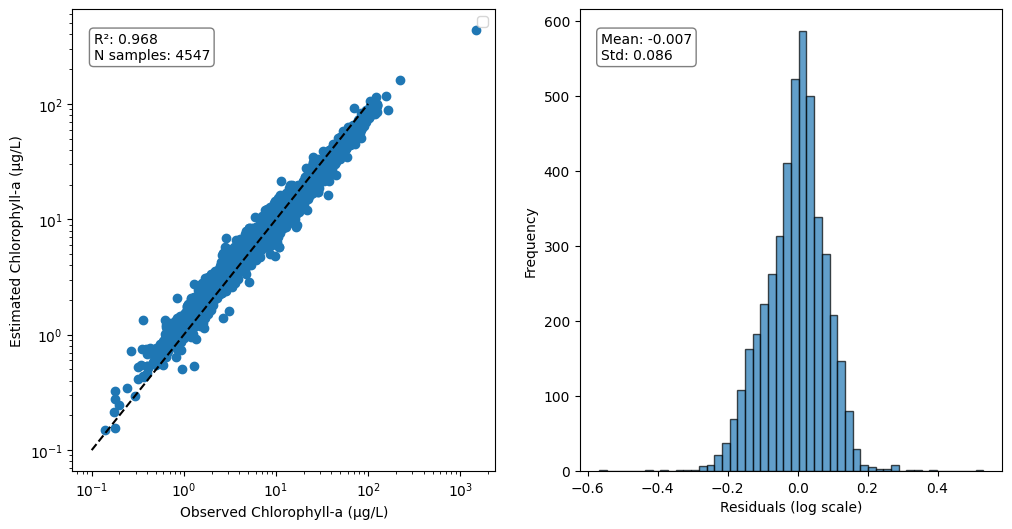

In [ ]:
fig, (ax, ax1) = plt.subplots(1, 2, figsize=(12, 6))


train_stats_df['residuals'] = train_stats_df['true_log_chl_a'] - train_stats_df['perc_50_log_chl_a']

train_residuals = train_stats_df['residuals']
train_residual_mean = train_residuals.mean()
train_residual_std = train_residuals.std()

train_1_std = train_stats_df[(train_stats_df['residuals'] >= (train_residual_mean - train_residual_std)) & (train_stats_df['residuals'] <= (train_residual_mean + train_residual_std))]
train_2_std = train_stats_df[(train_stats_df['residuals'] < (train_residual_mean - train_residual_std)) | (train_stats_df['residuals'] > (train_residual_mean + train_residual_std))]
print(f"Within 1 Std Dev: {len(train_1_std)} samples")
print(f"Within 2 Std Dev: {len(train_2_std)} samples")
ax.scatter(train_stats_df['true_chl_a'], train_stats_df['perc_50_chl_a'], alpha=1)

r2 = r2_score(train_stats_df['true_log_chl_a'], train_stats_df['perc_50_log_chl_a'])

ax.text(0.05, 0.95, f'R²: {r2:.3f}\nN samples: {len(train_stats_df)}', 
         transform=ax.transAxes, 
         verticalalignment='top',
         bbox=dict(boxstyle='round', facecolor='white', alpha=0.5))

ax.set_xscale('log')
ax.set_yscale('log')
ax.plot([0.1, 100], [0.1, 100], 'k--')  # 1:1 line
ax.set_xlabel('Observed Chlorophyll-a (µg/L)')
ax.set_ylabel('Estimated Chlorophyll-a (µg/L)')

# Plot histogram of residuals

# annotate mean and std on the plot
ax1.text(0.05, 0.95, f'Mean: {train_residual_mean:.3f}\nStd: {train_residual_std:.3f}',
            transform=ax1.transAxes, 
            verticalalignment='top',
            bbox=dict(boxstyle='round', facecolor='white', alpha=0.5))

ax1.hist(train_residuals, bins=50, alpha=0.7, edgecolor='black')
ax1.set_xlabel('Residuals (log scale)')
ax1.set_ylabel('Frequency')
ax.legend()

Within 1 Std Dev: 3123 samples
Within 2 Std Dev: 1424 samples


/var/folders/0q/tm370x9d1qdg6nt3w7pcqh_w0000gq/T/ipykernel_13613/3444208051.py:41: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


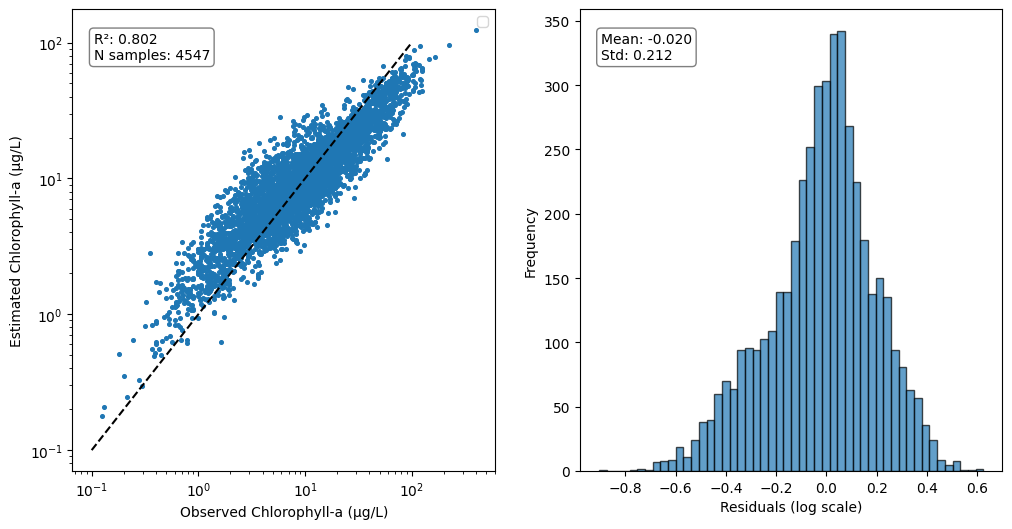

In [ ]:
fig, (ax, ax1) = plt.subplots(1, 2, figsize=(12, 6))


val_stats_df['residuals'] = val_stats_df['true_log_chl_a'] - val_stats_df['perc_50_log_chl_a']

val_residuals = val_stats_df['residuals']
val_residual_mean = val_residuals.mean()
val_residual_std = val_residuals.std()

val_1_std = val_stats_df[(val_stats_df['residuals'] >= (val_residual_mean - val_residual_std)) & (val_stats_df['residuals'] <= (val_residual_mean + val_residual_std))]
val_2_std = val_stats_df[(val_stats_df['residuals'] < (val_residual_mean - val_residual_std)) | (val_stats_df['residuals'] > (val_residual_mean + val_residual_std))]
print(f"Within 1 Std Dev: {len(val_1_std)} samples")
print(f"Within 2 Std Dev: {len(val_2_std)} samples")
# ax.scatter(val_2_std['true_chl_a'], val_2_std['perc_50_chl_a'], alpha=1, label='Residual > 1 Std', s=7, marker='x')
ax.scatter(val_stats_df['true_chl_a'], val_stats_df['perc_50_chl_a'], alpha=1, s=7)

r2 = r2_score(val_stats_df['true_log_chl_a'], val_stats_df['perc_50_log_chl_a'])

ax.text(0.05, 0.95, f'R²: {r2:.3f}\nN samples: {len(val_stats_df)}', 
         transform=ax.transAxes, 
         verticalalignment='top',
         bbox=dict(boxstyle='round', facecolor='white', alpha=0.5))

ax.set_xscale('log')
ax.set_yscale('log')
ax.plot([0.1, 100], [0.1, 100], 'k--')  # 1:1 line
ax.set_xlabel('Observed Chlorophyll-a (µg/L)')
ax.set_ylabel('Estimated Chlorophyll-a (µg/L)')

# Plot histogram of residuals

# annotate mean and std on the plot
ax1.text(0.05, 0.95, f'Mean: {val_residual_mean:.3f}\nStd: {val_residual_std:.3f}',
            transform=ax1.transAxes, 
            verticalalignment='top',
            bbox=dict(boxstyle='round', facecolor='white', alpha=0.5))

ax1.hist(val_residuals, bins=50, alpha=0.7, edgecolor='black')
ax1.set_xlabel('Residuals (log scale)')
ax1.set_ylabel('Frequency')
ax.legend()

Within 1 Std Dev: 1623 samples
Within 2 Std Dev: 548 samples


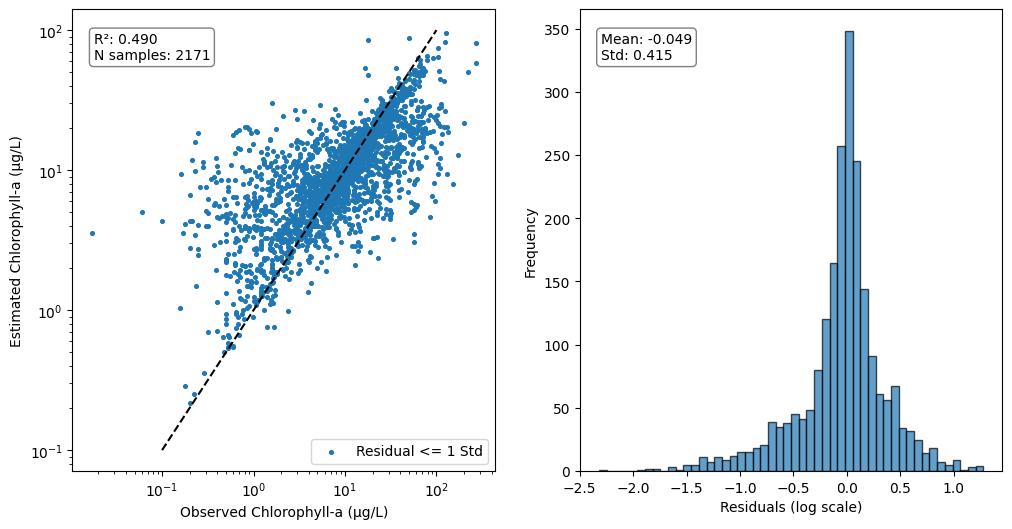

In [ ]:
fig, (ax, ax1) = plt.subplots(1, 2, figsize=(12, 6))


test_stats_df['residuals'] = test_stats_df['true_log_chl_a'] - test_stats_df['perc_50_log_chl_a']

test_residuals = test_stats_df['residuals']
test_residual_mean = test_residuals.mean()
test_residual_std = test_residuals.std()

test_1_std = test_stats_df[(test_stats_df['residuals'] >= (test_residual_mean - test_residual_std)) & (test_stats_df['residuals'] <= (test_residual_mean + test_residual_std))]
test_2_std = test_stats_df[(test_stats_df['residuals'] < (test_residual_mean - test_residual_std)) | (test_stats_df['residuals'] > (test_residual_mean + test_residual_std))]
print(f"Within 1 Std Dev: {len(test_1_std)} samples")
print(f"Within 2 Std Dev: {len(test_2_std)} samples")
# ax.scatter(test_2_std['true_chl_a'], test_2_std['perc_50_chl_a'], alpha=1, label='Residual > 1 Std', s=7, marker='x')
ax.scatter(test_stats_df['true_chl_a'], test_stats_df['perc_50_chl_a'], alpha=1, label='Residual <= 1 Std', s=7)

r2 = r2_score(test_stats_df['true_log_chl_a'], test_stats_df['perc_50_log_chl_a'])

ax.text(0.05, 0.95, f'R²: {r2:.3f}\nN samples: {len(test_stats_df)}', 
         transform=ax.transAxes, 
         verticalalignment='top',
         bbox=dict(boxstyle='round', facecolor='white', alpha=0.5))

ax.set_xscale('log')
ax.set_yscale('log')
ax.plot([0.1, 100], [0.1, 100], 'k--')  # 1:1 line
ax.set_xlabel('Observed Chlorophyll-a (µg/L)')
ax.set_ylabel('Estimated Chlorophyll-a (µg/L)')

# Plot histogram of residuals

# annotate mean and std on the plot
ax1.text(0.05, 0.95, f'Mean: {test_residual_mean:.3f}\nStd: {test_residual_std:.3f}',
            transform=ax1.transAxes, 
            verticalalignment='top',
            bbox=dict(boxstyle='round', facecolor='white', alpha=0.5))

ax1.hist(test_residuals, bins=50, alpha=0.7, edgecolor='black')
ax1.set_xlabel('Residuals (log scale)')
ax1.set_ylabel('Frequency')
ax.legend()

Text(0, 0.5, 'Estimated Chlorophyll-a (µg/L)')

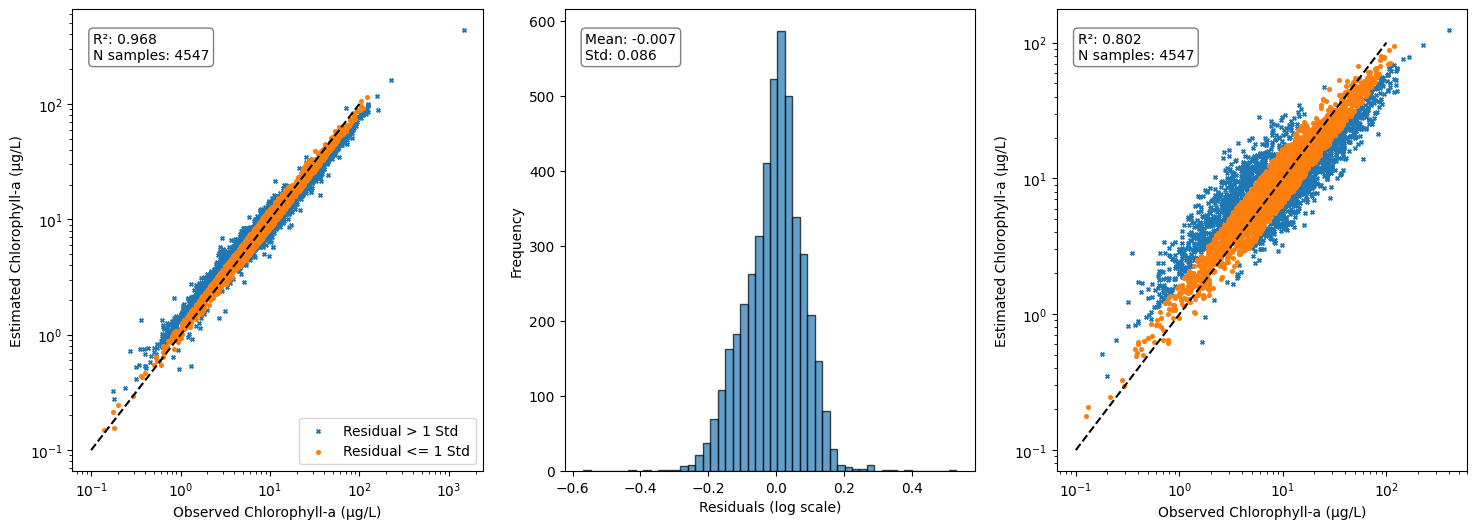

In [ ]:
fig, (ax, ax1, ax2) = plt.subplots(1, 3, figsize=(18, 6))
ax.scatter(train_2_std['true_chl_a'], train_2_std['perc_50_chl_a'], alpha=1, label='Residual > 1 Std', s=7, marker='x')
ax.scatter(train_1_std['true_chl_a'], train_1_std['perc_50_chl_a'], alpha=1, label='Residual <= 1 Std', s=7)

r2 = r2_score(train_stats_df['true_log_chl_a'], train_stats_df['perc_50_log_chl_a'])

ax.text(0.05, 0.95, f'R²: {r2:.3f}\nN samples: {len(train_stats_df)}', 
         transform=ax.transAxes, 
         verticalalignment='top',
         bbox=dict(boxstyle='round', facecolor='white', alpha=0.5))

ax.set_xscale('log')
ax.set_yscale('log')
ax.plot([0.1, 100], [0.1, 100], 'k--')  # 1:1 line
ax.set_xlabel('Observed Chlorophyll-a (µg/L)')
ax.set_ylabel('Estimated Chlorophyll-a (µg/L)')

# Plot histogram of residuals

# annotate mean and std on the plot
ax1.text(0.05, 0.95, f'Mean: {train_residual_mean:.3f}\nStd: {train_residual_std:.3f}',
            transform=ax1.transAxes, 
            verticalalignment='top',
            bbox=dict(boxstyle='round', facecolor='white', alpha=0.5))

ax1.hist(train_residuals, bins=50, alpha=0.7, edgecolor='black')
ax1.set_xlabel('Residuals (log scale)')
ax1.set_ylabel('Frequency')
ax.legend()


ax2.scatter(val_2_std['true_chl_a'], val_2_std['perc_50_chl_a'], alpha=1, label='Residual > 1 Std', s=7, marker='x')
ax2.scatter(val_1_std['true_chl_a'], val_1_std['perc_50_chl_a'], alpha=1, label='Residual <= 1 Std', s=7)

r2_val = r2_score(val_stats_df['true_log_chl_a'], val_stats_df['perc_50_log_chl_a'])

ax2.text(0.05, 0.95, f'R²: {r2_val:.3f}\nN samples: {len(val_stats_df)}', 
         transform=ax2.transAxes, 
         verticalalignment='top',
         bbox=dict(boxstyle='round', facecolor='white', alpha=0.5))

ax2.set_xscale('log')
ax2.set_yscale('log')
ax2.plot([0.1, 100], [0.1, 100], 'k--')  # 1:1 line
ax2.set_xlabel('Observed Chlorophyll-a (µg/L)')
ax2.set_ylabel('Estimated Chlorophyll-a (µg/L)')

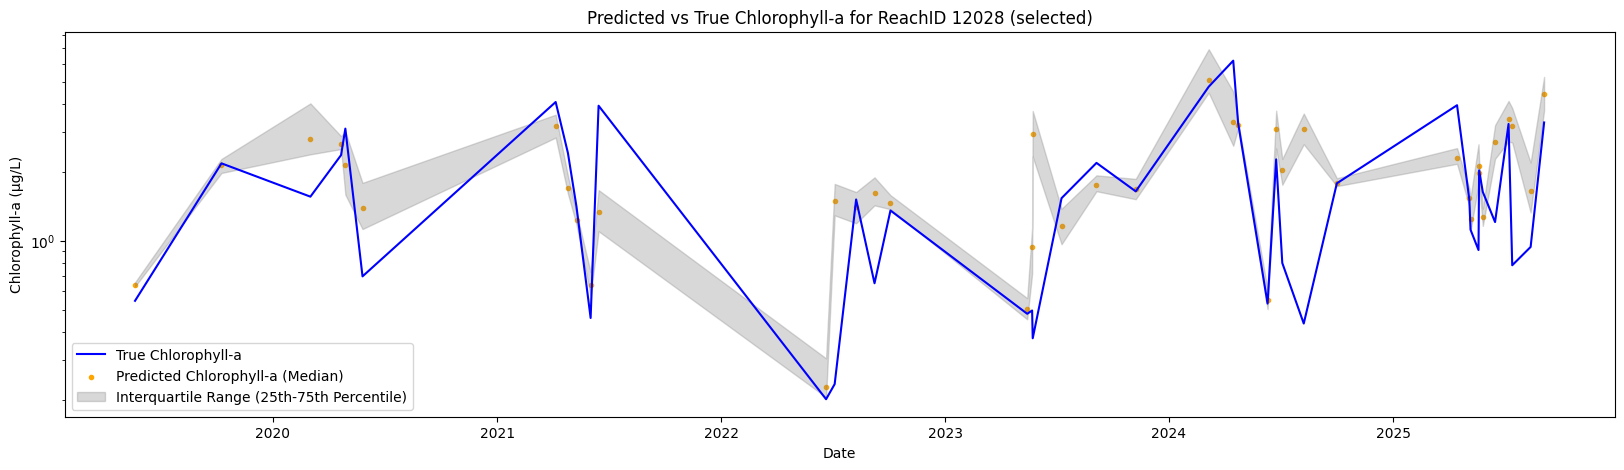

In [ ]:


selected_predictions = test_stats_df[test_stats_df['ReachID'] == 6928].copy()
selected_predictions['Date'] = pd.to_datetime(selected_predictions['Date'])
selected_predictions = selected_predictions.sort_values('Date')
# selected_predictions = pd.merge(selected_predictions, selected_insitu[['Date', 'chl_a', 'log_chl_a']], on=['Date'], how='right')

# # smooth the predictions using a rolling median
# selected_predictions['log_chl_a_smoothed'] = selected_predictions['log_chl_a'].rolling(window=7, center=True, min_periods=1).median()
# selected_predictions['chl_a_smoothed'] = 10**selected_predictions['log_chl_a_smoothed']

fig, ax = plt.subplots(figsize=(20, 5))
ax.plot(selected_predictions['Date'], selected_predictions['true_chl_a'], label='True Chlorophyll-a',color='blue')
ax.scatter(selected_predictions['Date'], selected_predictions['mean_chl_a'], label='Predicted Chlorophyll-a (Median)', s=9, color='orange')
ax.fill_between(selected_predictions['Date'], selected_predictions['perc_5_chl_a'], selected_predictions['perc_95_chl_a'], color='gray', alpha=0.3, label='Interquartile Range (25th-75th Percentile)')

# ax.set_yscale('log')

ax.set_xlabel('Date')
ax.set_ylabel('Chlorophyll-a (µg/L)')
ax.set_title('Predicted vs True Chlorophyll-a for ReachID 12028 (selected)')
ax.set_yscale('log')
ax.legend()

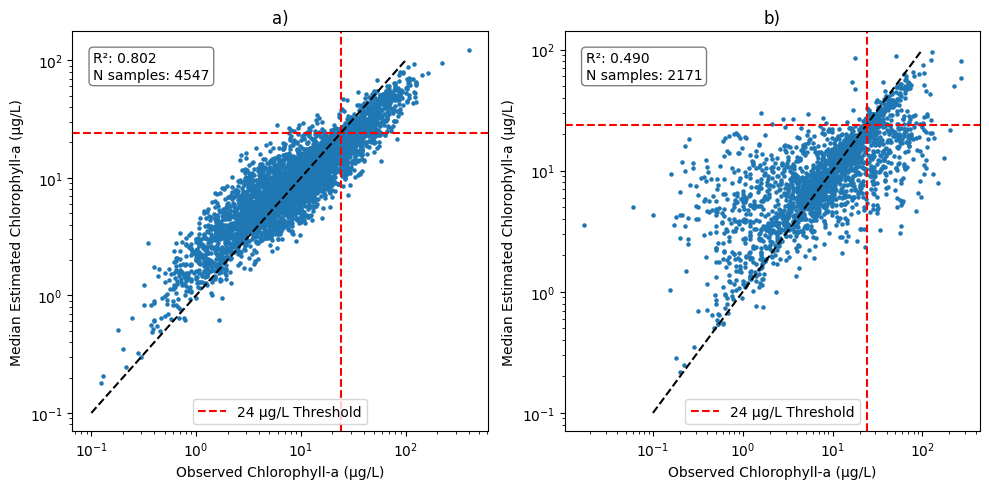

In [ ]:
fig, (ax, ax1) = plt.subplots(1, 2, figsize=(10, 5))

ax.scatter(val_stats_df['true_chl_a'], val_stats_df['perc_50_chl_a'], alpha=1,s=5)

r2 = r2_score(val_stats_df['true_log_chl_a'], val_stats_df['perc_50_log_chl_a'])

ax.text(0.05, 0.95, f'R²: {r2:.3f}\nN samples: {len(val_stats_df)}', 
         transform=ax.transAxes, 
         verticalalignment='top',
         bbox=dict(boxstyle='round', facecolor='white', alpha=0.5))

ax.set_xscale('log')
ax.set_yscale('log')
ax.axvline(x=24, color='red', linestyle='--', label='24 µg/L Threshold')
ax.axhline(y=24, color='red', linestyle='--')
ax.plot([0.1, 100], [0.1, 100], 'k--')  # 1:1 line
ax.set_xlabel('Observed Chlorophyll-a (µg/L)')
ax.set_ylabel('Median Estimated Chlorophyll-a (µg/L)')
ax.legend(loc='lower center')

ax1.scatter(test_stats_df['true_chl_a'], test_stats_df['perc_50_chl_a'], alpha=1, s=5)

r2 = r2_score(test_stats_df['true_log_chl_a'], test_stats_df['perc_50_log_chl_a'])

ax1.text(0.05, 0.95, f'R²: {r2:.3f}\nN samples: {len(test_stats_df)}', 
         transform=ax1.transAxes, 
         verticalalignment='top',
         bbox=dict(boxstyle='round', facecolor='white', alpha=0.5))

ax1.set_xscale('log')
ax1.set_yscale('log')
ax1.plot([0.1, 100], [0.1, 100], 'k--')  # 1:1 line
ax1.set_xlabel('Observed Chlorophyll-a (µg/L)')
ax1.set_ylabel('Median Estimated Chlorophyll-a (µg/L)')
ax1.axvline(x=24, color='red', linestyle='--', label='24 µg/L Threshold')
ax1.axhline(y=24, color='red', linestyle='--')
ax1.legend()

ax.set_title('a)')
ax1.set_title('b)')

fig.tight_layout()
fig.savefig('validation_test_scatter.png', dpi=300)

In [ ]:
ax.scatter(val_stats_df['true_chl_a'], val_stats_df['perc_50_chl_a'], alpha=1, label='Residual <= 1 Std', s=7)

r2 = r2_score(val_stats_df['true_log_chl_a'], val_stats_df['perc_50_log_chl_a'])

ax.text(0.05, 0.95, f'R²: {r2:.3f}\nN samples: {len(val_stats_df)}', 
         transform=ax.transAxes, 
         verticalalignment='top',
         bbox=dict(boxstyle='round', facecolor='white', alpha=0.5))

ax.set_xscale('log')
ax.set_yscale('log')
ax.plot([0.1, 100], [0.1, 100], 'k--')  # 1:1 line
ax.set_xlabel('Observed Chlorophyll-a (µg/L)')
ax.set_ylabel('Median Estimated Chlorophyll-a (µg/L)')

Within 1 Std Dev: 1623 samples
Within 2 Std Dev: 548 samples


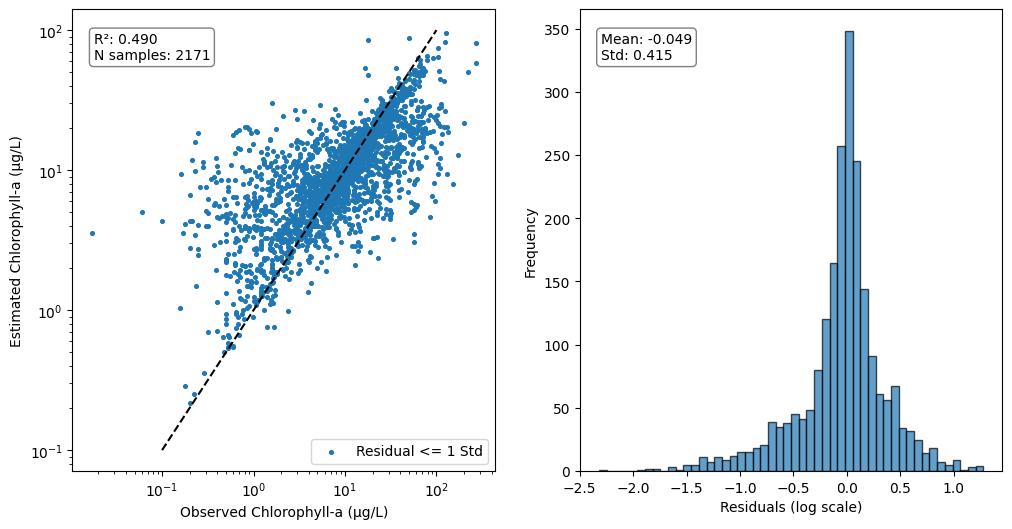

In [ ]:
fig, (ax, ax1) = plt.subplots(1, 2, figsize=(12, 6))


test_stats_df['residuals'] = test_stats_df['true_log_chl_a'] - test_stats_df['perc_50_log_chl_a']

test_residuals = test_stats_df['residuals']
test_residual_mean = test_residuals.mean()
test_residual_std = test_residuals.std()

test_1_std = test_stats_df[(test_stats_df['residuals'] >= (test_residual_mean - test_residual_std)) & (test_stats_df['residuals'] <= (test_residual_mean + test_residual_std))]
test_2_std = test_stats_df[(test_stats_df['residuals'] < (test_residual_mean - test_residual_std)) | (test_stats_df['residuals'] > (test_residual_mean + test_residual_std))]
print(f"Within 1 Std Dev: {len(test_1_std)} samples")
print(f"Within 2 Std Dev: {len(test_2_std)} samples")
# ax.scatter(test_2_std['true_chl_a'], test_2_std['perc_50_chl_a'], alpha=1, label='Residual > 1 Std', s=7, marker='x')
ax.scatter(test_stats_df['true_chl_a'], test_stats_df['perc_50_chl_a'], alpha=1, label='Residual <= 1 Std', s=7)

r2 = r2_score(test_stats_df['true_log_chl_a'], test_stats_df['perc_50_log_chl_a'])

ax.text(0.05, 0.95, f'R²: {r2:.3f}\nN samples: {len(test_stats_df)}', 
         transform=ax.transAxes, 
         verticalalignment='top',
         bbox=dict(boxstyle='round', facecolor='white', alpha=0.5))

ax.set_xscale('log')
ax.set_yscale('log')
ax.plot([0.1, 100], [0.1, 100], 'k--')  # 1:1 line
ax.set_xlabel('Observed Chlorophyll-a (µg/L)')
ax.set_ylabel('Estimated Chlorophyll-a (µg/L)')

# Plot histogram of residuals

# annotate mean and std on the plot
ax1.text(0.05, 0.95, f'Mean: {test_residual_mean:.3f}\nStd: {test_residual_std:.3f}',
            transform=ax1.transAxes, 
            verticalalignment='top',
            bbox=dict(boxstyle='round', facecolor='white', alpha=0.5))

ax1.hist(test_residuals, bins=50, alpha=0.7, edgecolor='black')
ax1.set_xlabel('Residuals (log scale)')
ax1.set_ylabel('Frequency')
ax.legend()

## HAB Classification (Precision/Recall/F1)

In [ ]:
# validation set
val_tp = len(val_stats_df[(val_stats_df['true_chl_a'] >= 24) & (val_stats_df['perc_50_chl_a'] >= 24)])
val_fp = len(val_stats_df[(val_stats_df['true_chl_a'] < 24) & (val_stats_df['perc_50_chl_a'] >= 24)])
val_tn = len(val_stats_df[(val_stats_df['true_chl_a'] < 24) & (val_stats_df['perc_50_chl_a'] < 24)])
val_fn = len(val_stats_df[(val_stats_df['true_chl_a'] >= 24) & (val_stats_df['perc_50_chl_a'] < 24)])

print(f"Validation Set - TP: {val_tp}, FP: {val_fp}, TN: {val_tn}, FN: {val_fn}")

Validation Set - TP: 508, FP: 37, TN: 3681, FN: 321


In [ ]:
# testidation set
test_tp = len(test_stats_df[(test_stats_df['true_chl_a'] >= 24) & (test_stats_df['perc_50_chl_a'] >= 24)])
test_fp = len(test_stats_df[(test_stats_df['true_chl_a'] < 24) & (test_stats_df['perc_50_chl_a'] >= 24)])
test_tn = len(test_stats_df[(test_stats_df['true_chl_a'] < 24) & (test_stats_df['perc_50_chl_a'] < 24)])
test_fn = len(test_stats_df[(test_stats_df['true_chl_a'] >= 24) & (test_stats_df['perc_50_chl_a'] < 24)])

print(f"testidation Set - TP: {test_tp}, FP: {test_fp}, TN: {test_tn}, FN: {test_fn}")

testidation Set - TP: 203, FP: 22, TN: 1690, FN: 256


In [ ]:
val_precision = val_tp / (val_tp + val_fp) if (val_tp + val_fp) > 0 else 0
val_recall = val_tp / (val_tp + val_fn) if (val_tp + val_fn) > 0 else 0
val_f1_score = 2 * (val_precision * val_recall) / (val_precision + val_recall) if (val_precision + val_recall) > 0 else 0

print(f"Validation Set - Precision: {val_precision:.3f}, Recall: {val_recall:.3f}, F1 Score: {val_f1_score:.3f}")

Validation Set - Precision: 0.932, Recall: 0.613, F1 Score: 0.739


In [ ]:
test_precision = test_tp / (test_tp + test_fp) if (test_tp + test_fp) > 0 else 0
test_recall = test_tp / (test_tp + test_fn) if (test_tp + test_fn) > 0 else 0
test_f1_score = 2 * (test_precision * test_recall) / (test_precision + test_recall) if (test_precision + test_recall) > 0 else 0

print(f"testidation Set - Precision: {test_precision:.3f}, Recall: {test_recall:.3f}, F1 Score: {test_f1_score:.3f}")

testidation Set - Precision: 0.902, Recall: 0.442, F1 Score: 0.594


## Time series plots

In [12]:
hls_insitu = pd.read_csv(project_dir / 'data/hls_insitu/hls_insitu.csv', low_memory=False)
hls_insitu['Date'] = pd.to_datetime(hls_insitu['Date'])
hls_insitu['log_chl_a'] = np.log10(hls_insitu['chl_a'])
hls_insitu['doy'] = hls_insitu['Date'].dt.dayofyear

reach_12028 = hls_insitu[hls_insitu['ReachID'] == 12028].copy()
reach_12028 = reach_12028.sort_values('Date')

reach_11634 = hls_insitu[hls_insitu['ReachID'] == 11634].copy()
reach_11634 = reach_11634.sort_values('Date')

reach_7557 = hls_insitu[hls_insitu['ReachID'] == 7557].copy()
reach_7557 = reach_7557.sort_values('Date')

del hls_insitu

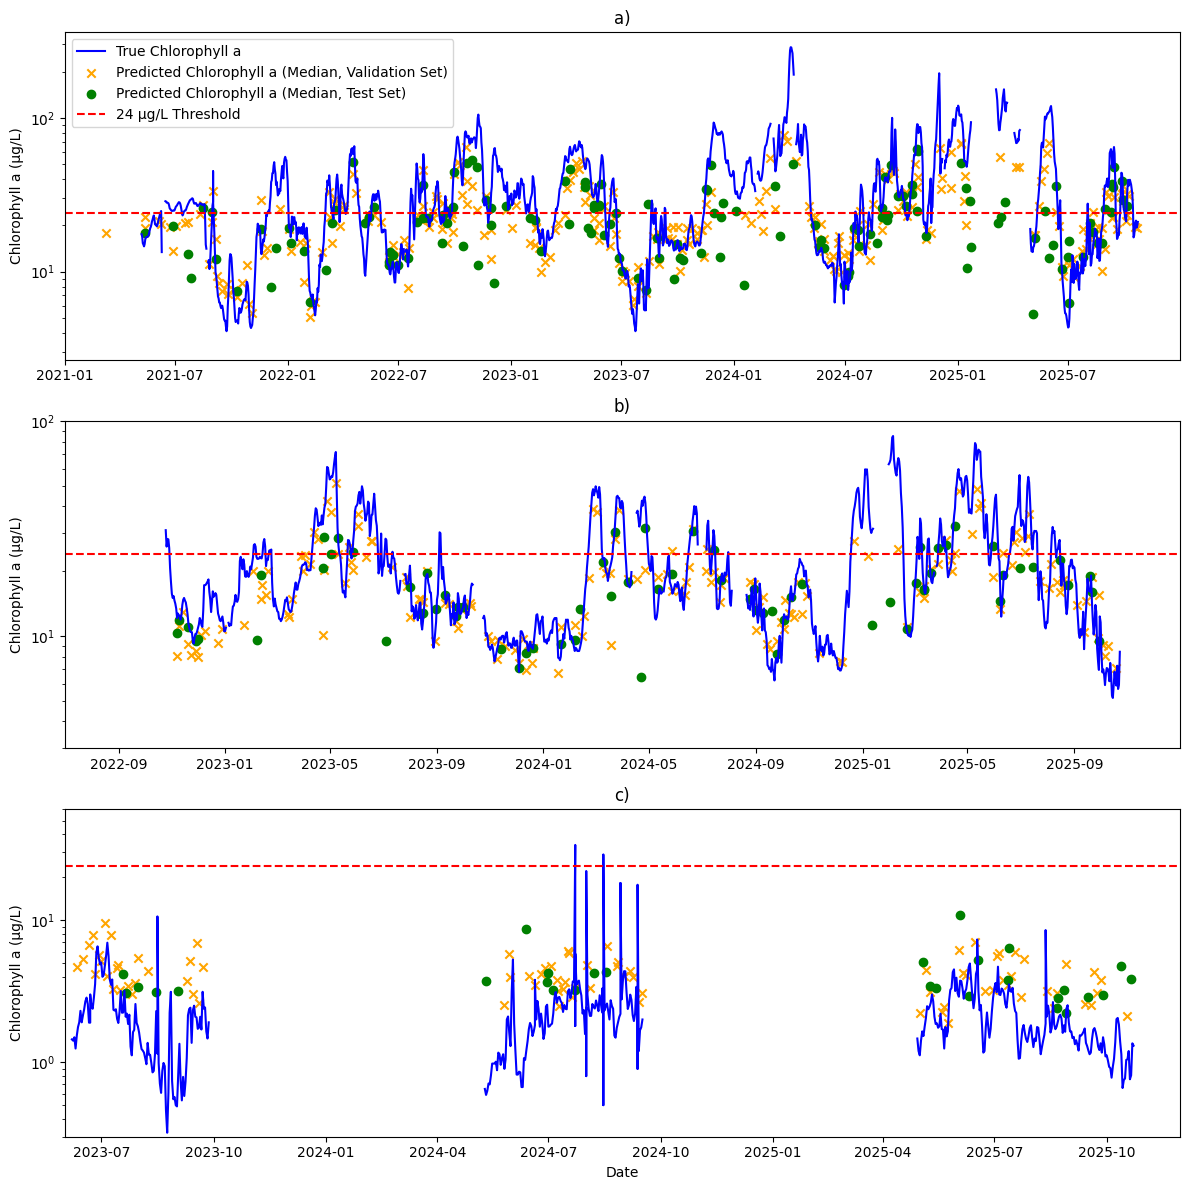

In [15]:
# plot a timeseries of the predictions and true values for reach 12028, 11634, and 7557
fig, (ax, ax1, ax2) = plt.subplots(3, 1, figsize=(12, 12))
ax.plot(
    reach_12028["Date"],
    reach_12028["chl_a"],
    label="True Chlorophyll a",
    color="blue",
)
ax.scatter(
    val_stats_df[val_stats_df["ReachID"] == 12028]["Date"],
    val_stats_df[val_stats_df["ReachID"] == 12028]["perc_50_chl_a"],
    label="Predicted Chlorophyll a (Median, Validation Set)",
    marker='x',
    color="orange",
)
ax.scatter(
    test_stats_df[test_stats_df["ReachID"] == 12028]["Date"],
    test_stats_df[test_stats_df["ReachID"] == 12028]["perc_50_chl_a"],
    label="Predicted Chlorophyll a (Median, Test Set)",  # s=9,
    marker='o',
    color="green",
)
# ax.fill_between(val_stats_df[val_stats_df['ReachID'] == 12028]['Date'], val_stats_df[val_stats_df['ReachID'] == 12028]['perc_5_chl_a'], val_stats_df[val_stats_df['ReachID'] == 12028]['perc_95_chl_a'], color='gray', alpha=0.3, label='Interquartile Range (25th-75th Percentile, ReachID 12028)')

ax.axhline(y=24, color="red", linestyle="--", label="24 µg/L Threshold")

ax.set_yscale("log")
ax.set_xlim([pd.to_datetime("2021-01-01"), pd.to_datetime("2025-12-31")])
# ax.set_xlabel("Date")
ax.set_ylabel("Chlorophyll a (µg/L)")
ax.set_title("a)")
ax.legend()


ax1.plot(
    reach_11634["Date"],
    reach_11634["chl_a"],
    label="True Chlorophyll a (ReachID 11634)",
    color="blue",
)
ax1.scatter(
    val_stats_df[val_stats_df["ReachID"] == 11634]["Date"],
    val_stats_df[val_stats_df["ReachID"] == 11634]["perc_50_chl_a"],
    label="Predicted Chlorophyll a (Median, Validation Set)",
    marker='x',
    color="orange",
)
ax1.scatter(
    test_stats_df[test_stats_df["ReachID"] == 11634]["Date"],
    test_stats_df[test_stats_df["ReachID"] == 11634]["perc_50_chl_a"],
    label="Predicted Chlorophyll a (Median, Test Set)",  # s=9,
    marker='o',
    color="green",
)
# ax1.fill_between(val_stats_df[val_stats_df['ReachID'] == 11634]['Date'], val_stats_df[val_stats_df['ReachID'] == 11634]['perc_5_chl_a'], val_stats_df[val_stats_df['ReachID'] == 11634]['perc_95_chl_a'], color='gray', alpha=0.3, label='Interquartile Range (25th-75th Percentile, ReachID 11634)')

ax1.axhline(y=24, color="red", linestyle="--", label="24 µg/L Threshold")

ax1.set_yscale("log")
ax1.set_xlim([pd.to_datetime("2022-07-01"), pd.to_datetime("2025-12-31")])
ax1.set_ylim([3, 100])
ax1.set_ylabel("Chlorophyll a (µg/L)")
ax1.set_title("b)")
# ax1.legend()


ax2.plot(
    reach_7557["Date"],
    reach_7557["chl_a"],
    label="True Chlorophyll a (ReachID 7557)",
    color="blue",
)
ax2.scatter(
    val_stats_df[val_stats_df["ReachID"] == 7557]["Date"],
    val_stats_df[val_stats_df["ReachID"] == 7557]["perc_50_chl_a"],
    label="Predicted Chlorophyll a (Median, Validation Set)",
    marker='x',
    color="orange",
)
ax2.scatter(
    test_stats_df[test_stats_df["ReachID"] == 7557]["Date"],
    test_stats_df[test_stats_df["ReachID"] == 7557]["perc_50_chl_a"],
    label="Predicted Chlorophyll a (Median, Test Set)",  # s=9,
    marker='o',
    color="green",
)
# ax2.fill_between(val_stats_df[val_stats_df['ReachID'] == 7557]['Date'], val_stats_df[val_stats_df['ReachID'] == 7557]['perc_5_chl_a'], val_stats_df[val_stats_df['ReachID'] == 7557]['perc_95_chl_a'], color='gray', alpha=0.3, label='Interquartile Range (25th-75th Percentile, ReachID 7557)')

ax2.axhline(y=24, color="red", linestyle="--", label="24 µg/L Threshold")

ax2.set_yscale("log")
ax2.set_xlim([pd.to_datetime("2023-06-01"), pd.to_datetime("2025-11-30")])
ax2.set_ylim([.3, 60])
ax2.set_xlabel("Date")
ax2.set_ylabel("Chlorophyll a (µg/L)")
ax2.set_title("c)")
# ax2.legend()

fig.tight_layout()
fig.savefig('reach_chl_timeseries.png', dpi=300)

